
Enter #Number of CSV dataset (triplicate, etc) : 3

Enter files path : C:\Users\baptiste.overney\Desktop\Injection test_Qui_100ppm
Enter file name 1 : 20200709_0323
Enter file name 2 : 20200709_0428
Enter file name 3 : 20200709_0444



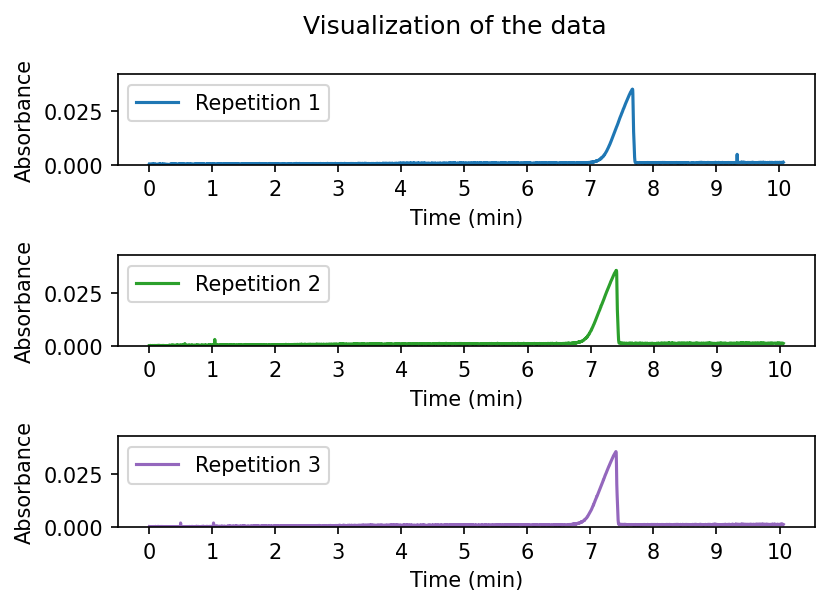

Enter #Number of peaks per dataset : 1

Enter threshold (#Number between 0 and 1) of peak detection (normally 0.5, if error try 0.3) : 0.5

With the help of the following electrophoregrams you will have to choose the #Start and #End values for the integration of the peaks



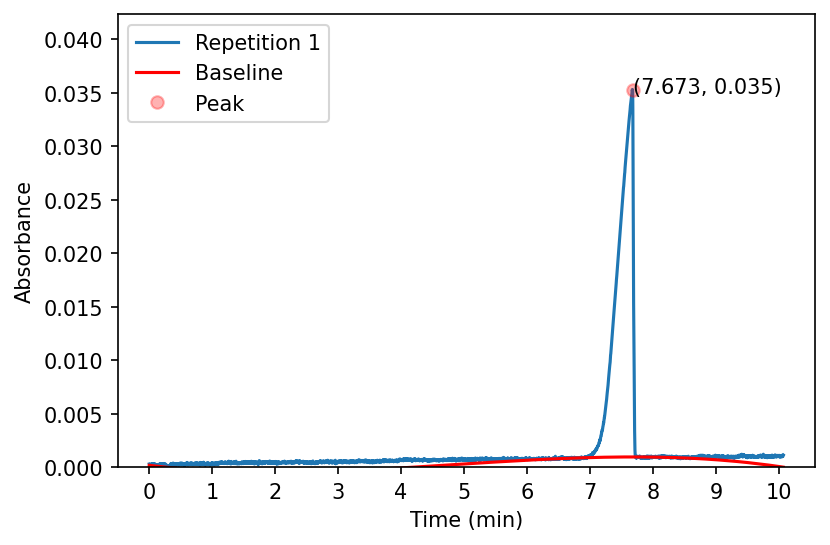

Enter #START value (on X axis) of integration for Repetition 1 Peak 1 : 6.5
Enter #END value (on X axis) of integration for Repetition 1 Peak 1 : 8



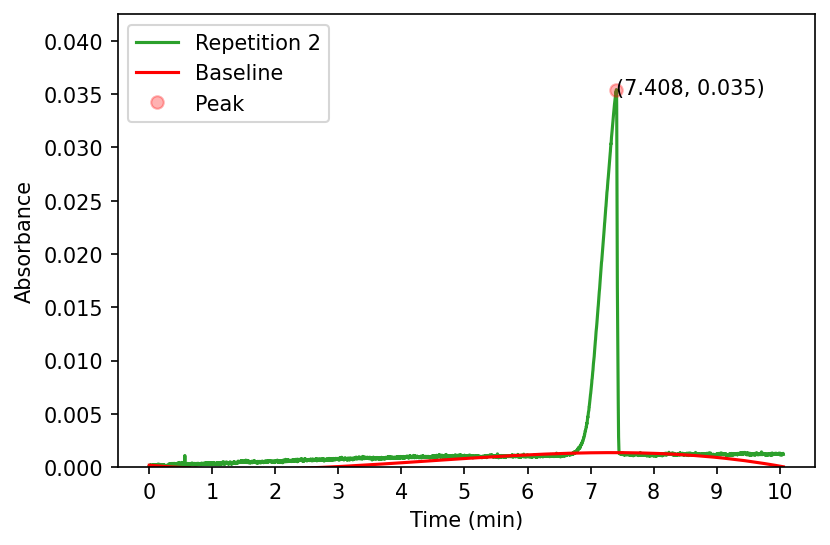

Enter #START value (on X axis) of integration for Repetition 2 Peak 1 : 6.5
Enter #END value (on X axis) of integration for Repetition 2 Peak 1 : 8



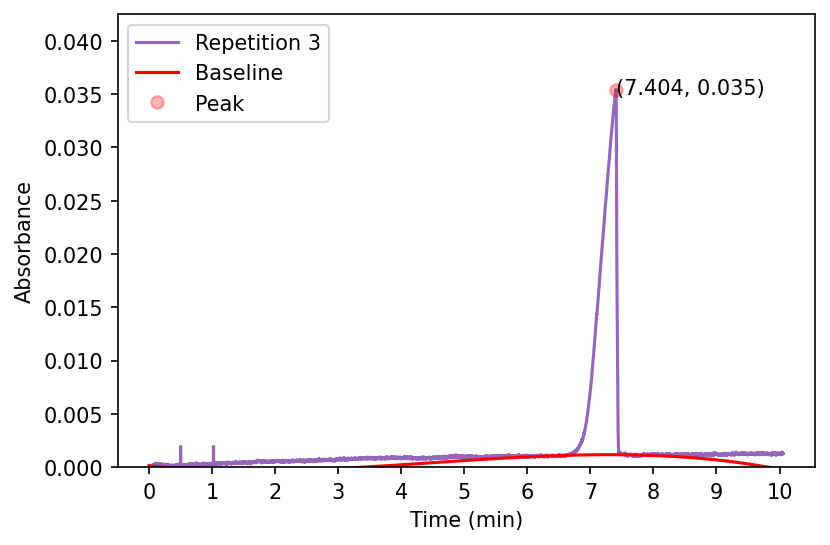

Enter #START value (on X axis) of integration for Repetition 3 Peak 1 : 6.5
Enter #END value (on X axis) of integration for Repetition 3 Peak 1 : 8

Is there a internal standard ? (Y / N) : N

Area = 
            1           2           3  Mean (min)   RSD (%)
1  0.00937201  0.00909704  0.00947984    0.009316  1.729967

Peaks retention time = 
          1         2       3  Mean (min)  RSD (%)
1  7.673167  7.407833  7.4045    7.495167  1.67938

Area/time = 
           1           2           3  Mean (-)  RSD (%)
1  0.0012214  0.00122803  0.00128028  0.001243  2.11815

Enter x limit left for the subplot: 5
Enter x limit right for the subplot: 10


<IPython.core.display.Javascript object>


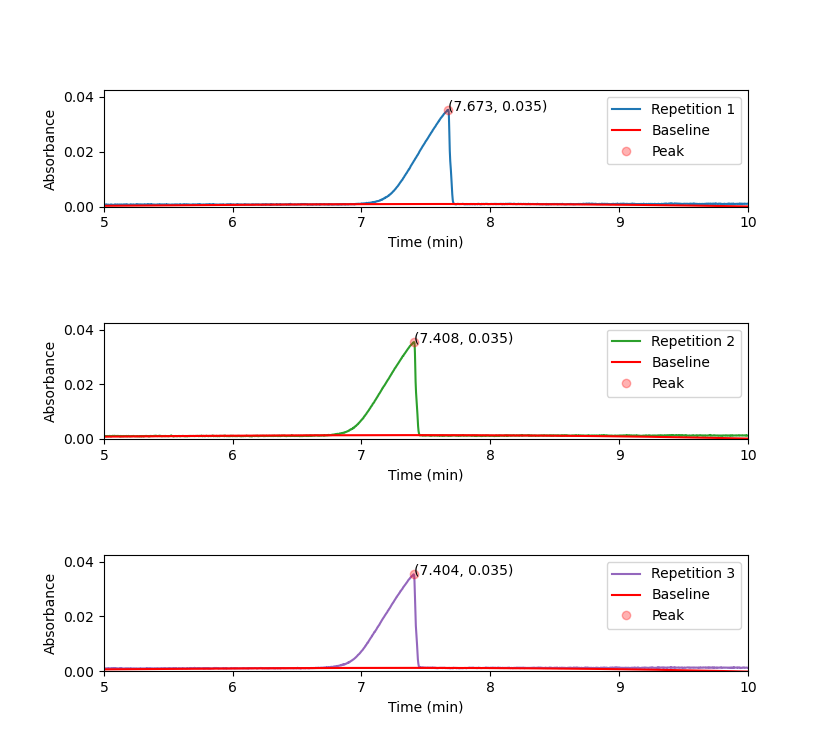

In [1]:
import numpy as np
import pandas as pd
import peakutils
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import integrate

plt.rcParams['figure.dpi'] = 150

np.seterr(divide='ignore', invalid='ignore')
print()
CSV_nb = int(input('Enter #Number of CSV dataset (triplicate, etc) : '))
print()
wd = input("Enter files path : ")
for i in range(1, CSV_nb + 1):
    # Import CSV
    filename = input('Enter file name {} : '.format(i))
    globals()['Repetition{}'.format(i)] = pd.read_csv(wd + '\\' + filename + '.csv', skiprows=[k for k in range(1, 21)],
                                                      header=[1])
print()
for i in range(1, CSV_nb + 1):
    # Drop duplicates
    globals()['Repetition{}'.format(i)] = globals()['Repetition{}'.format(i)].drop_duplicates(subset=['Time {s}']). \
        reset_index(drop=True)

col_names1 = []
for i in range(1, CSV_nb + 1):
    col_names1.append('{}'.format(i))

time = pd.DataFrame(columns=col_names1)
Abs_rep = pd.DataFrame(columns=col_names1)

for i in range(1, CSV_nb + 1):
    # Time in {min
    time['{}'.format(i)] = globals()['Repetition{}'.format(i)]['Time {s}'] / 60  # min
    # Absorbance calculation from intensity values
    Abs_rep['{}'.format(i)] = globals()['Repetition{}'.format(i)]['Absorbance {}']

# Drop NaN (if the dataset are not of the same size, the last rows will be filled with NaN)
# --> dropping the last rows of the dataframe will not affect the results
time.dropna(inplace=True)
Abs_rep.dropna(inplace=True)

# Remove zero values by calculating the mean between the point before and after
for i in range(1, CSV_nb + 1):
    Zero = []
    # Remove 0 values by calculating mean point before and after
    if Abs_rep['{}'.format(i)].eq(0).any().any() == True:
        Zero.append(Abs_rep[Abs_rep['{}'.format(i)] == 0].index)
        for j in range(0, len(Zero[0])):
            Abs_rep['{}'.format(i)][Zero[0][j]] = (Abs_rep['{}'.format(i)][Zero[0][j] - 1] +
                                                Abs_rep['{}'.format(i)][Zero[0][j] + 1]) / 2

for i in range(1, CSV_nb + 1):
    Abs_rep['{}'.format(i)] = np.log10(Abs_rep['{}'.format(i)].max() / Abs_rep['{}'.format(i)])

# First plot to visualize Data
cplot = pd.DataFrame()
cplot['Sequential'] = [
    'tab:blue', 'tab:green', 'tab:purple', 'tab:cyan', 'tab:pink', 'tab:brown',
    'tab:grey', 'tab:olive', 'tab:orange']

for i in range(1, CSV_nb + 1):
    plt.subplot(int(str(CSV_nb) + str(1) + str(i)))
    plt.subplots_adjust(hspace = 1)
    plt.plot(time['{}'.format(i)], Abs_rep['{}'.format(i)], '-', c=cplot['Sequential'][i - 1],
             label='Repetition {}'.format(i))
    plt.suptitle('Visualization of the data')
    plt.xlabel('Time (min)')
    plt.ylabel('Absorbance')
    plt.ylim(0, np.max(Abs_rep['{}'.format(i)]) * 1.2)
    plt.xticks(np.arange(0, np.max(time['{}'.format(i)]),step=1))
    plt.legend()
plt.show()

dAbs_rep = pd.DataFrame(columns=col_names1)
outlier_datapoints = []

for i in range(1, CSV_nb + 1):
    # 1st derivative
    dAbs_rep['{}'.format(i)] = np.diff(Abs_rep['{}'.format(i)]) / np.diff(time['{}'.format(i)])

for i in range(1, CSV_nb + 1):
    # Removing outliers
    outliers = []
    outlier_idx = []


    def detect_outlier(data):
        threshold = 20
        mean = data.mean()
        std = data.std()

        for y in data:
            z_score = (y - mean) / std
            if z_score > threshold:
                outliers.append(y)
        return outliers


    outlier_datapoints = detect_outlier(dAbs_rep['{}'.format(i)])
    if not len(outlier_datapoints) == 0:
        for j in range(0, len(outlier_datapoints)):
            outlier_idx.append(dAbs_rep[dAbs_rep['{}'.format(i)] == outlier_datapoints[j]].index + 1)
        for j in range(0, len(outlier_idx)):
            Abs_rep['{}'.format(i)][outlier_idx[j][0]] = (Abs_rep['{}'.format(i)][outlier_idx[j][0] - 1] + Abs_rep[
                '{}'.format(i)][outlier_idx[j][0] + 1]) / 2

Peak_nb = int(input('Enter #Number of peaks per dataset : '))
print()

idx_nb = []
for j in range(0, Peak_nb):
    idx_nb.append(j)

baseline_values = pd.DataFrame(columns=col_names1)
idx_peaks = pd.DataFrame(columns=col_names1)
Abs_peak = pd.DataFrame(columns=col_names1, index=idx_nb)
time_peak = pd.DataFrame(columns=col_names1, index=idx_nb)

Threshold = float(input('Enter threshold (#Number between 0 and 1) of peak detection ('
                        'normally 0.5, if error try 0.3) : '))
print()

for i in range(1, CSV_nb + 1):
    # Baseline determination
    baseline_values['{}'.format(i)] = peakutils.baseline(Abs_rep['{}'.format(i)])

    # Peak identification
    idx_peaks['{}'.format(i)] = peakutils.indexes(Abs_rep['{}'.format(i)], thres=Threshold, min_dist=200,
                                                  thres_abs=False)

    for j in range(0, Peak_nb):
        Abs_peak['{}'.format(i)][j] = Abs_rep['{}'.format(i)][idx_peaks['{}'.format(i)][j]]
        time_peak['{}'.format(i)][j] = time['{}'.format(i)][idx_peaks['{}'.format(i)][j]]
Abs_peak = Abs_peak.astype(float)
time_peak = time_peak.astype(float)


def find_nearest(df, value):
    df = pd.DataFrame(df)
    idx = np.asarray(abs(df - value).idxmin())
    return idx


Start = pd.DataFrame(columns=col_names1, index=idx_nb)
End = pd.DataFrame(columns=col_names1, index=idx_nb)

print('With the help of the following electrophoregrams you will have to choose the #Start and #End values for the '
      'integration of the peaks')
print()


for i in range(1, CSV_nb + 1):
    # Integrals and plot
    plt.plot(time['{}'.format(i)], Abs_rep['{}'.format(i)], '-', c=cplot['Sequential'][i - 1],
             label='Repetition {}'.format(i))
    plt.plot(time['{}'.format(i)], baseline_values['{}'.format(i)], 'r-', markersize=0.1, label='Baseline')
    plt.plot(time_peak['{}'.format(i)], Abs_peak['{}'.format(i)], 'ro', alpha=0.3, label='Peak')
    for xy in zip(np.round(time_peak['{}'.format(i)], 3), np.round(Abs_peak['{}'.format(i)], 3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Time (min)')
    plt.ylabel('Absorbance')
    plt.ylim(0, np.max(Abs_rep['{}'.format(i)]) * 1.2)
    plt.xticks(np.arange(0, np.max(time['{}'.format(i)]),step=1))
    plt.legend(loc='upper left')
    plt.show()

    for j, k in zip(range(0, Peak_nb), range(1, Peak_nb + 1)):
        Start['{}'.format(i)][j] = find_nearest(time['{}'.format(i)], float(input(
            "Enter #START value (on X axis) of integration for Repetition {} ".format(i) + "Peak {} : ".format(k))))
        End['{}'.format(i)][j] = find_nearest(time['{}'.format(i)], float(input(
            "Enter #END value (on X axis) of integration for Repetition {} ".format(i) + "Peak {} : ".format(k))))
    print()

Area = pd.DataFrame(columns=col_names1, index=idx_nb)
Area_time = pd.DataFrame(columns=col_names1, index=idx_nb)
for i in range(1, CSV_nb + 1):
    for j in range(0, Peak_nb):
        Area['{}'.format(i)][j] = integrate.trapz(Abs_rep['{}'.format(i)][Start['{}'.format(i)][j][0]:End[
            '{}'.format(i)][j][0]], time['{}'.format(i)][Start['{}'.format(i)][j][0]:End['{}'.format(
                i)][j][0]]) - integrate.trapz(baseline_values['{}'.format(i)][Start['{}'.format(
                    i)][j][0]:End['{}'.format(i)][j][0]], time['{}'.format(i)][Start[
                        '{}'.format(i)][j][0]:End['{}'.format(i)][j][0]])
        Area_time['{}'.format(i)][j] = Area['{}'.format(i)][j] / time_peak['{}'.format(i)][j]
        
# Final calculations an prints
# Which one is the internal standard
IS = input('Is there a internal standard ? (Y / N) : ')
print()
if IS == 'Y':
    IS_NB = int(input('Enter #Number of the Internal Standard peak (from left side starting from 1): '))
    print()

    # Start dataframe from index 1 instead of zero
    Area.index = Area.index + 1
    Area_time.index = Area_time.index + 1
    time_peak.index = time_peak.index + 1

    # Select internal standard row from DataFrame
    IS_Area = Area.iloc[[IS_NB - 1]]
    IS_Area_time = Area_time.iloc[[IS_NB - 1]]

    # Mean and RSD calculation
    # Area
    Area['Mean (min)'] = Area.mean(axis=1)
    Area['RSD (%)'] = Area.std(axis=1) / Area.mean(axis=1) * 100
    print('Area = \n%s' % Area)
    print()

    # Peak retention time
    time_peak['Mean (min)'] = time_peak.mean(axis=1)
    time_peak['RSD (%)'] = time_peak.std(axis=1) / time_peak.mean(axis=1) * 100
    print('Peaks retention time = \n%s' % time_peak)
    print()

    # Area/time
    Area_time['Mean (-)'] = Area_time.mean(axis=1)
    Area_time['RSD (%)'] = Area_time.std(axis=1) / Area_time.mean(axis=1) * 100
    print('Area/time = \n%s' % Area_time)
    print()

    # Drop internal std row from DataFrame
    Area = Area.drop(IS_NB, axis=0)
    Area_time = Area_time.drop(IS_NB, axis=0)

    # Normalization with internal standard
    idx_nb = []
    for j in [x for x in range(1, Peak_nb + 1) if x != IS_NB]:
        idx_nb.append(j)

    Area_IS = pd.DataFrame(columns=col_names1, index=idx_nb)
    Area_time_IS = pd.DataFrame(columns=col_names1, index=idx_nb)

    for i in range(1, CSV_nb + 1):
        for j in [x for x in range(1, Peak_nb + 1) if x != IS_NB]:
            Area_IS['{}'.format(i)][j] = Area['{}'.format(i)][j] / IS_Area['{}'.format(i)][IS_NB]
            Area_time_IS['{}'.format(i)][j] = Area_time['{}'.format(i)][j] / IS_Area_time['{}'.format(i)][IS_NB]

    Area_IS['Mean (-)'] = Area_IS.mean(axis=1)
    Area_IS['RSD (%)'] = Area_IS.std(axis=1) / Area_IS.mean(axis=1) * 100
    print('Area / Internal Standard = \n%s' % Area_IS)
    print()

    Area_time_IS['Mean (1/min)'] = Area_time_IS.mean(axis=1)
    Area_time_IS['RSD (%)'] = Area_time_IS.std(axis=1) / Area_time_IS.mean(axis=1) * 100
    print('Area/time / Internal Standard/time = \n%s' % Area_time_IS)
    print()
else:
    # Start dataframe from index 1 instead of zero
    Area.index = Area.index + 1
    Area_time.index = Area_time.index + 1
    time_peak.index = time_peak.index + 1

    # Mean and RSD calculation
    # Area
    Area['Mean (min)'] = Area.mean(axis=1)
    Area['RSD (%)'] = Area.std(axis=1) / Area.mean(axis=1) * 100
    print('Area = \n%s' % Area)
    print()

    # Peak retention time
    time_peak['Mean (min)'] = time_peak.mean(axis=1)
    time_peak['RSD (%)'] = time_peak.std(axis=1) / time_peak.mean(axis=1) * 100
    print('Peaks retention time = \n%s' % time_peak)
    print()

    # Area/time
    Area_time['Mean (-)'] = Area_time.mean(axis=1)
    Area_time['RSD (%)'] = Area_time.std(axis=1) / Area_time.mean(axis=1) * 100
    print('Area/time = \n%s' % Area_time)
    print()

# SubPlot
x_1 = float(input("Enter x limit left for the subplot: "))
x_2 = float(input("Enter x limit right for the subplot: "))

%matplotlib notebook
for i in range(1, CSV_nb + 1):
    plt.subplot(int(str(CSV_nb) + str(1) + str(i)))
    plt.subplots_adjust(hspace = 1)
    plt.plot(time['{}'.format(i)], Abs_rep['{}'.format(i)], '-', c=cplot['Sequential'][i - 1],
             label='Repetition {}'.format(i))
    plt.plot(time['{}'.format(i)], baseline_values['{}'.format(i)], 'r-', markersize=0.1, label='Baseline')
    plt.plot(time_peak['{}'.format(i)], Abs_peak['{}'.format(i)], 'ro', alpha=0.3, label='Peak')
    for xy in zip(np.round(time_peak['{}'.format(i)], 3), np.round(Abs_peak['{}'.format(i)], 3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.xlabel('Time (min)')
    plt.ylabel('Absorbance')
    plt.xlim(x_1, x_2)
    plt.ylim(0, np.max(Abs_rep['{}'.format(i)]) * 1.2)
    plt.legend()
plt.show()